In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import random, torch.backends.cudnn as cudnn
import re
import math
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from rtdl_revisiting_models import  FTTransformer
from torch.utils.data import WeightedRandomSampler, DataLoader, Dataset
from sklearn.metrics import r2_score, accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from imblearn.over_sampling import SMOTENC
from tabm import TabM

In [2]:
df = pd.read_csv("convert_json_data.csv")
# df = df.iloc[:50_000].copy()
LABEL_ONLY_COLS = ["category_group"]
CATEGORICAL_FEATURES = [        
    'currency',
    'country_displayable_name',
    'location_state',
]
NUMERIC_FEATURES = [
    'goal_usd_log',
    'name_len',
    'blurb_len',
    'has_video', 
    'days_diff_launched_at_deadline_log',
    'goal_per_day_log',
    'goal_rank_in_cat',
    'goal_vs_cat_median',
    'goal_vs_country_median',
    'goal_round_100',
    'goal_round_1000',
    'cat_freq',
    'country_freq',
    'cat_x_country_freq',
    'gpd_rank_in_cat',
    'gpd_vs_cat_median',
    'gpd_dist_cat_median',
    'cat_country_share',
    'prep_days',
    'has_photo',
    'launch_dow',
    'deadline_dow',
    'too_short_or_long',
]
CYCLIC_NUMERIC = [ 
    'deadline_mon_sin',
    'deadline_mon_cos',
    'deadline_dom_sin',
    'deadline_dom_cos',  
    'launched_at_mon_sin',
    'launched_at_mon_cos',
    'launched_at_dom_sin',
    'launched_at_dom_cos',  
]

FEATURES = CATEGORICAL_FEATURES + NUMERIC_FEATURES

In [3]:
label_encoders = {}
for col in CATEGORICAL_FEATURES:
    df[col] = df[col].fillna("missing").astype(str)
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
for col in LABEL_ONLY_COLS:
    df[col] = df[col].fillna("missing").astype(str)
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col]) 
    label_encoders[col] = le

In [4]:
TARGET_FEATURE = {
    "success_cls": df["state"].to_numpy(dtype=np.int64),
    # "success_rate_cls": df["success_rate_cls"].to_numpy(dtype=np.int64),
    "risk_level": df["risk_level"].to_numpy(dtype=np.int64),
    "days_to_state_change": df["duration_class"].to_numpy(dtype=np.int64),
    "recommend_category": df["category_group"].to_numpy(dtype=np.int64),
    "goal_eval": df["goal_eval"].to_numpy(dtype=np.int64),
    # "shortfall_severity_cls": df["shortfall_severity_cls"].to_numpy(dtype=np.int64),
    "stretch_potential_cls": df["stretch_potential_cls"].to_numpy(dtype=np.int64),
}

key = df["category_group"].astype(str) + "_" + df["state"].astype(str)
idx_train, idx_val = train_test_split(np.arange(len(df)), test_size=0.2, random_state=42, stratify=key)

X_train_df = df.iloc[idx_train]
X_val_df = df.iloc[idx_val]



In [5]:
def split_counts(df, col, idx_train, idx_val):
    tr = df.loc[idx_train, col].value_counts().sort_index()
    va = df.loc[idx_val,   col].value_counts().sort_index()
    out = pd.concat([tr.rename("train"), va.rename("val")], axis=1
          ).fillna(0).astype(int)
    return out

print(split_counts(df, "risk_level", idx_train, idx_val))
print(split_counts(df, "success_rate_cls", idx_train, idx_val))
print(split_counts(df, "state", idx_train, idx_val))
print(split_counts(df, "duration_class", idx_train, idx_val))
print(split_counts(df, "category_group", idx_train, idx_val))
print(split_counts(df, "shortfall_severity_cls", idx_train, idx_val))
print(split_counts(df, "stretch_potential_cls", idx_train, idx_val))


            train   val
risk_level             
0            9528  2392
1            9530  2390
2            9550  2370
                  train   val
success_rate_cls             
0                 10720  2677
1                   366    87
2                   453   120
3                 10119  2576
4                  3187   776
5                  3763   916
       train   val
state             
0      11140  2787
1      17468  4365
                train   val
duration_class             
0                7114  1826
1                7160  1780
2                7187  1753
3                7147  1793
                train  val
category_group            
0                2861  715
1                2861  715
2                2861  715
3                2861  715
4                2860  716
5                2860  716
6                2861  715
7                2861  715
8                2861  715
9                2861  715
                        train   val
shortfall_severity_cls             


In [6]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [7]:
for name, df in [("train", X_train_df), ("val", X_val_df)]:
    print(name, "duration:", df["duration_class"].value_counts(normalize=True).sort_index().round(3).to_dict())

train duration: {0: 0.249, 1: 0.25, 2: 0.251, 3: 0.25}
val duration: {0: 0.255, 1: 0.249, 2: 0.245, 3: 0.251}


In [8]:
cat_cardinalities = [int(X_train_df[col].max()) + 1 for col in CATEGORICAL_FEATURES]
print("✅ FINAL cat_cardinalities =", cat_cardinalities)

✅ FINAL cat_cardinalities = [15, 25, 710]


In [9]:
class MultiTaskDataset(torch.utils.data.Dataset):
    def __init__(self, x_cat, x_cont, y_dict):
        self.x_cat = x_cat
        self.x_cont = x_cont
        self.y_dict = y_dict
        self.keys = list(y_dict.keys())

    def __len__(self):
        return len(self.x_cat)

    def __getitem__(self, idx):
        return (
            self.x_cat[idx],
            self.x_cont[idx],
            {k: self.y_dict[k][idx] for k in self.keys}
        )

y_train_dict = {
    k: torch.tensor(v[idx_train]) for k, v in TARGET_FEATURE.items()
}
y_val_dict = {
    k: torch.tensor(v[idx_val]) for k, v in TARGET_FEATURE.items()
}




combined_train = (
    X_train_df["name"].fillna("").str.lower() + " " +
    X_train_df["blurb"].fillna("").str.lower() + " " +
    X_train_df["category_slug"].fillna("").str.replace("/", " ").str.lower()
).tolist()

combined_val = (
    X_val_df["name"].fillna("").str.lower() + " " +
    X_val_df["blurb"].fillna("").str.lower() + " " +
    X_val_df["category_slug"].fillna("").str.replace("/", " ").str.lower()
).tolist()

tfidf = TfidfVectorizer(min_df=3, max_df=0.9, ngram_range=(1,2), stop_words='english')
X_tfidf_tr = tfidf.fit_transform(combined_train)
X_tfidf_va = tfidf.transform(combined_val)

svd_dim = 128
svd = TruncatedSVD(n_components=svd_dim, random_state=42)
X_txt_tr = svd.fit_transform(X_tfidf_tr)
X_txt_va = svd.transform(X_tfidf_va)

scaler = StandardScaler()
numeric_scaled = scaler.fit_transform(X_train_df[NUMERIC_FEATURES])
numeric_scaled_val = scaler.transform(X_val_df[NUMERIC_FEATURES])

X_cont_train = np.concatenate([numeric_scaled, X_txt_tr, X_train_df[CYCLIC_NUMERIC]], axis=1)
X_cont_val = np.concatenate([numeric_scaled_val, X_txt_va, X_val_df[CYCLIC_NUMERIC]], axis=1)

x_cont_tensor = torch.tensor(X_cont_train, dtype=torch.float32)
x_cont_val = torch.tensor(X_cont_val, dtype=torch.float32)

x_cat_tensor = torch.tensor(X_train_df[CATEGORICAL_FEATURES].values, dtype=torch.long)
x_cat_val = torch.tensor(X_val_df[CATEGORICAL_FEATURES].values, dtype=torch.long)

train_ds = MultiTaskDataset(x_cat_tensor, x_cont_tensor, y_train_dict)
val_ds = MultiTaskDataset(x_cat_val, x_cont_val, y_val_dict)




# ===== DataLoaders =====
BATCH_SIZE = 256  # ของคุณเดิม
idx = np.arange(len(train_ds))
# ปกติ (ไม่ oversample) ใช้เฉพาะช่วง warmup และเอาไว้เทียบ
train_loader_plain = DataLoader(train_ds,
                                batch_size=BATCH_SIZE,
                                shuffle=True,
                                drop_last=False)

# Validation ไม่แตะ (ห้าม oversample)
val_loader = DataLoader(val_ds,
                        batch_size=BATCH_SIZE,
                        shuffle=False,
                        drop_last=False)



In [10]:
for k in y_train_dict:
    y_train_dict[k] = y_train_dict[k].long()
for k in y_val_dict:
    y_val_dict[k] = y_val_dict[k].long()

num_classes_map = {
    k: int(y_train_dict[k].max().item() + 1)
    for k in y_train_dict.keys()
}
print(num_classes_map)

{'success_cls': 2, 'risk_level': 3, 'days_to_state_change': 4, 'recommend_category': 10, 'goal_eval': 3, 'stretch_potential_cls': 3}


In [11]:
import torch
import torch.nn as nn

class MultiHeadWrapper(nn.Module):
    def __init__(self, base_model: nn.Module, head_dims: dict, in_dim: int, d_hidden: int = 64):
        super().__init__()
        self.backbone = base_model
        self.in_dim = in_dim

        def make_head(out_dim, hidden=d_hidden, dropout=0.2):
            return nn.Sequential(
                nn.Linear(in_dim, hidden),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden, out_dim),
            )

        # ---- หัวหลัก (ประกาศแบบแยก ไม่ใช้ลูป) ----
        self.head_success_cls = make_head(head_dims["success_cls"]) if "success_cls" in head_dims else None
        self.head_risk_level = make_head(head_dims["risk_level"]) if "risk_level" in head_dims else None

        self.head_days_to_state_change = (
            nn.Sequential(
                nn.Linear(in_dim, 256),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(256, head_dims["days_to_state_change"]),
            ) if "days_to_state_change" in head_dims else None
        )

        self.head_recommend_category = (
            nn.Sequential(
                nn.Linear(in_dim, 256),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(256, head_dims["recommend_category"]),
            ) if "recommend_category" in head_dims else None
        )

        self.head_goal_eval = make_head(head_dims["goal_eval"]) if "goal_eval" in head_dims else None

        # ---- 3 หัวใหม่ (มีคีย์ถึงจะสร้าง) ----
        self.head_stretch_potential_cls = (
            make_head(head_dims["stretch_potential_cls"]) if "stretch_potential_cls" in head_dims else None
        )
        self.head_shortfall_severity_cls = (
            make_head(head_dims["shortfall_severity_cls"]) if "shortfall_severity_cls" in head_dims else None
        )
        self.head_near_miss_cls = (
            make_head(head_dims["near_miss_cls"]) if "near_miss_cls" in head_dims else None
        )

    def forward(self, x_cont, x_cat):
        x = self.backbone(x_cont, x_cat)  # [B, in_dim]
        out = {}

        if self.head_success_cls is not None:
            out["success_cls"] = self.head_success_cls(x)
        if self.head_risk_level is not None:
            out["risk_level"] = self.head_risk_level(x)
        if self.head_days_to_state_change is not None:
            out["days_to_state_change"] = self.head_days_to_state_change(x)
        if self.head_recommend_category is not None:
            out["recommend_category"] = self.head_recommend_category(x)
        if self.head_goal_eval is not None:
            out["goal_eval"] = self.head_goal_eval(x)

        if self.head_stretch_potential_cls is not None:
            out["stretch_potential_cls"] = self.head_stretch_potential_cls(x)
        if self.head_shortfall_severity_cls is not None:
            out["shortfall_severity_cls"] = self.head_shortfall_severity_cls(x)
        if self.head_near_miss_cls is not None:
            out["near_miss_cls"] = self.head_near_miss_cls(x)

        return out


In [12]:
d_model_out_dim = 256
n_cont_features = X_cont_train.shape[1] 
backbone = FTTransformer(
    n_cont_features=n_cont_features,  # ใช้ตามจริงจาก data
    cat_cardinalities=cat_cardinalities,
    d_out=256,
    n_blocks=3,
    d_block=96,
    attention_n_heads=2,
    attention_dropout=0.25,
    ffn_d_hidden_multiplier=4 / 3,
    ffn_dropout=0.25,
    residual_dropout=0.1,
)
# backbone = TabM.make(
#     n_num_features=n_cont_features,
#     cat_cardinalities=cat_cardinalities,  # One-hot encoding will be used.
#     d_out=d_model_out_dim,
# )

head_dims = {
    "success_cls": 2,
    # "success_rate_cls": 6,
    "risk_level": 3,
    "days_to_state_change": 4,
    "recommend_category": len(label_encoders["category_group"].classes_),
    "goal_eval": 3,
    # "shortfall_severity_cls": 4,
    "stretch_potential_cls": 3,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiHeadWrapper(backbone, head_dims, in_dim=d_model_out_dim).to(device)

In [13]:
print("Model is running on:", next(model.parameters()).device)
print("CUDA available:", torch.cuda.is_available())
print(torch.__version__)
print(torch.version.cuda)

Model is running on: cuda:0
CUDA available: True
2.7.1+cu118
11.8


In [14]:
print({k: len(np.unique(v)) for k, v in TARGET_FEATURE.items()})

{'success_cls': 2, 'risk_level': 3, 'days_to_state_change': 4, 'recommend_category': 10, 'goal_eval': 3, 'stretch_potential_cls': 3}


In [15]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


In [16]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight: torch.Tensor | None = None, reduction='mean'):
        super().__init__()
        self.gamma = float(gamma)
        self.reduction = reduction
        # เก็บ weight เป็น buffer (ย้าย device ตามโมดูล, ไม่อัปเดตกราด)
        if weight is not None:
            self.register_buffer('weight', weight.float())
        else:
            self.weight = None

    def forward(self, logits: torch.Tensor, target: torch.Tensor):
        logp = F.log_softmax(logits, dim=-1)
        p = logp.exp()
        w = self.weight
        if w is not None and w.device != logits.device:
            w = w.to(logits.device)
        loss = F.nll_loss(((1 - p) ** self.gamma) * logp,
                          target, weight=w, reduction='none')
        return loss.mean() if self.reduction == 'mean' else loss.sum()

# --- คำนวณ class weight จาก label ทั้งชุด (ไม่ต้องอ้าง logits) ---
def class_weights_from_labels(y: torch.Tensor, num_classes: int) -> torch.Tensor:
    y_cpu = y.detach().view(-1).cpu().long()
    cnt = torch.bincount(y_cpu, minlength=num_classes).float()
    inv = cnt.sum() / cnt.clamp_min(1)     # inverse frequency
    w = inv / inv.mean()                    # normalize ให้มีค่าเฉลี่ย ~1
    return w

# ตัวอย่างการสร้าง weight และผูกเข้ากับ loss ฟังก์ชัน
C_risk    = num_classes_map['risk_level']
C_stretch = num_classes_map['stretch_potential_cls']

w_risk    = class_weights_from_labels(y_train_dict['risk_level'],            C_risk)
w_stretch = class_weights_from_labels(y_train_dict['stretch_potential_cls'], C_stretch)


In [17]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [18]:
def feature_dropout(x_cont, drop_prob=0.05):
    if drop_prob <= 0: return x_cont
    mask = (torch.rand_like(x_cont) < drop_prob).float()
    return x_cont * (1 - mask)   


In [19]:
ORDINAL_HEADS = {}
# ORDINAL_HEADS = {"success_rate_cls"}
def corn_targets(y, num_classes):
    B = y.size(0); K = num_classes
    t = torch.arange(K-1, device=y.device).unsqueeze(0).expand(B, -1)
    return (y.unsqueeze(1) > t).float()

def corn_loss(logits, y, pos_weight=None):
    tgt = corn_targets(y, logits.size(1) + 1)
    return F.binary_cross_entropy_with_logits(
        logits, tgt, pos_weight=pos_weight, reduction="mean"
    )

def corn_predict(logits):
    p = torch.sigmoid(logits)
    return (p > 0.5).sum(dim=1)

In [20]:
SORD_HEADS = {}   
def _sord_targets(y, C, tau=0.75, device=None):
    y = y.view(-1, 1).long()
    cls = torch.arange(C, device=device).view(1, -1)
    dist = (cls - y).abs().float()
    p = torch.softmax(-dist / tau, dim=1)
    return p

_kl = nn.KLDivLoss(reduction='batchmean')

def sord_loss(logits, y, tau=0.75):
    C = logits.size(1)
    p = _sord_targets(y, C, tau=tau, device=logits.device)   # soft target
    return _kl(F.log_softmax(logits, dim=1), p)



In [21]:
class AutomaticWeightedLoss(nn.Module):
    """automatically weighted multi-task loss

    Params：
        num: int，the number of loss
        x: multi-task loss
    Examples：
        loss1=1
        loss2=2
        awl = AutomaticWeightedLoss(2)
        loss_sum = awl(loss1, loss2)
    """
    def __init__(self, num=2):
        super(AutomaticWeightedLoss, self).__init__()
        params = torch.ones(num, requires_grad=True)
        self.params = torch.nn.Parameter(params)

    def forward(self, *x):
        loss_sum = 0
        for i, loss in enumerate(x):
            loss_sum += 0.5 / (self.params[i] ** 2) * loss + torch.log(1 + self.params[i] ** 2)
        return loss_sum

if __name__ == '__main__':
    awl = AutomaticWeightedLoss(2)
    print(awl.parameters())
    
PRIOR_HEADS  = {"stretch_potential_cls", "risk_level"}
HEADS_ORDER  = ["success_cls", "risk_level", "days_to_state_change",
                "recommend_category", "goal_eval", "stretch_potential_cls"]
OTHERS_ORDER = [h for h in HEADS_ORDER if h not in PRIOR_HEADS]

# สร้าง AWL ด้วยจำนวนหัวที่ตรงกับ OTHERS_ORDER
awl = AutomaticWeightedLoss(len(OTHERS_ORDER)).to(device)

<generator object Module.parameters at 0x000001DC230244A0>


In [22]:
# # นับจำนวนคลาส (ใช้จาก y_train_dict เดิม)
# y_sf_np = y_train_dict["shortfall_severity_cls"].numpy()
# num_sf = num_classes_map["shortfall_severity_cls"]
# counts_sf = np.bincount(y_sf_np, minlength=num_sf)

# def effective_num_weights(counts: np.ndarray, beta: float = 0.9999, normalize_to_mean: bool = True):
#     eff = 1.0 - np.power(beta, counts.astype(np.float64))
#     w = (1.0 - beta) / np.maximum(eff, 1e-12)
#     if normalize_to_mean:
#         w = w / (w.mean() + 1e-12)
#     return torch.tensor(w, dtype=torch.float32)

# # class weights สำหรับ CB-Focal และ sampling
# w_sf = effective_num_weights(counts_sf, beta=0.9999).to(device)            # ใช้ใน loss (alpha_k)
# w_sf_for_sampler = effective_num_weights(counts_sf, beta=0.9999).to(device) # ใช้ทำ sampler
# w_boost = w_sf_for_sampler.clone()
# w_boost[1] *= 2.5   # บูสต์คลาส 1
# w_boost[2] *= 1.2   # บูสต์คลาส 2
# alpha = 0.5  # 0.5–0.7 ลองกวาดได้
# w_temp = w_sf_for_sampler.pow(alpha)

# # prior + log-prior สำหรับ Logit Adjustment (LA)
# prior_sf = (counts_sf + 1e-12) / counts_sf.sum()
# log_prior_sf = torch.tensor(np.log(prior_sf), dtype=torch.float32, device=device)

# def tau_schedule(epoch, num_epochs, tau_max=0.25, warm_frac=0.6):
#     t = min(1.0, epoch/(num_epochs*warm_frac))
#     return tau_max * t


# # Focal Loss รองรับ class weights (alpha_k) สำหรับแบบ multiclass
# class FocalLoss(nn.Module):
#     def __init__(self, gamma=2.0, weight=None, reduction='mean'):
#         super().__init__()
#         # ยอมรับ gamma เป็น tensor [C]
#         self.gamma = torch.tensor(gamma) if not torch.is_tensor(gamma) else gamma
#         self.weight = weight
#         self.reduction = reduction
#     def forward(self, logits, target):
#         logp = F.log_softmax(logits, dim=1)
#         p = logp.exp()
#         logp_t = logp.gather(1, target.unsqueeze(1)).squeeze(1)
#         p_t = p.gather(1, target.unsqueeze(1)).squeeze(1)
#         # ใช้ gamma ของคลาสจริง
#         gamma_t = self.gamma.to(logits.device)[target]
#         loss = -(1 - p_t).pow(gamma_t) * logp_t
#         if self.weight is not None:
#             loss = loss * self.weight[target]
#         return loss.mean() if self.reduction=='mean' else loss.sum() if self.reduction=='sum' else loss

# # สร้าง gamma_c จาก prior (คลาสยิ่งน้อย -> gamma ยิ่งสูง)
# pi = torch.tensor(prior_sf, dtype=torch.float32)
# gamma_per_class = 1.0 + (1.5 * (1 - pi / pi.max())) 

# # กำหนด DRW: ช่วงแรกใช้ CE ธรรมดา / หลัง drw_start ใช้ CB-Focal
# # drw_start = 5       # เริ่มใช้ CB-Focal ตั้งแต่ epoch นี้เป็นต้นไป (ปรับได้)
# # focal_gamma = 2.0     # พลัง Focal

# # ce_shortfall       = nn.CrossEntropyLoss(weight=w_sf, reduction='mean')
# # cb_focal_shortfall = FocalLoss(gamma=focal_gamma, weight=w_sf, reduction='mean')

# # Oversampler สำหรับช่วง warmup (แทน make_multitask_sampler เดิม)
# def make_sampler_from_class_weights(class_weights: torch.Tensor, y_np: np.ndarray):
#     w_per_sample = class_weights.cpu().numpy()[y_np]
#     w_per_sample = w_per_sample / (w_per_sample.mean() + 1e-12)
#     w_per_sample = torch.as_tensor(w_per_sample, dtype=torch.double)  # ✅
#     return WeightedRandomSampler(weights=w_per_sample,
#                                  num_samples=len(y_np),
#                                  replacement=True)


# sampler_os = make_sampler_from_class_weights(w_temp, y_sf_np)
# train_loader_os = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler_os, drop_last=False)
# # NOTE: val_loader ใช้ของเดิม (ห้าม oversample)


In [23]:

# ==== CONFIG ====
num_epochs     = 50
warmup_epochs  = 5        
patience       = 10
focal_gamma = 1.5
FOCUS_CFG = {
    "stretch_potential_cls": {"max": 12.0, "ramp": 3},  # ดันแรงกว่านิดหน่อย
    "risk_level":            {"max": 12.0, "ramp": 3},  # ค่อยๆ ไล่ (ถ้ายังนิ่งค่อยเพิ่ม max เป็น 8)
}

def get_focus_scale(head: str, epoch: int) -> float:
    # ช่วง warmup ไม่บูสต์
    if epoch < warmup_epochs:
        return 1.0
    cfg = FOCUS_CFG.get(head)
    if cfg is None:  # หัวอื่นๆ ไม่บูสต์
        return 1.0
    t = min(1.0, (epoch - warmup_epochs) / max(1, cfg["ramp"]))
    return 1.0 + (cfg["max"] - 1.0) * t
# ==== Loss dicts ====
loss_fn_warmup = {
    "success_cls":            nn.CrossEntropyLoss(),
    # "success_rate_cls":       nn.CrossEntropyLoss(label_smoothing=0.1),  
    "risk_level":             nn.CrossEntropyLoss(),  
    "days_to_state_change":   nn.CrossEntropyLoss(),
    "recommend_category":     nn.CrossEntropyLoss(),
    "goal_eval":              nn.CrossEntropyLoss(),
    # "shortfall_severity_cls": nn.CrossEntropyLoss(),
    "stretch_potential_cls":  nn.CrossEntropyLoss(),
}

# ช่วง post: คมขึ้นเล็กน้อย และมี class weight สำหรับสองหัวสำคัญ (สมมติ cw มีอยู่แล้ว)
loss_fn_post = {
    "success_cls":            nn.CrossEntropyLoss(label_smoothing=0.1),
    # "success_rate_cls":       nn.CrossEntropyLoss(label_smoothing=0.1),
    "risk_level":             FocalLoss(gamma=2.0, weight=w_risk),
    "days_to_state_change":   nn.CrossEntropyLoss(label_smoothing=0.1),
    "recommend_category":     nn.CrossEntropyLoss(label_smoothing=0.1),
    "goal_eval":              nn.CrossEntropyLoss(label_smoothing=0.1),
    # "shortfall_severity_cls": FocalLoss(gamma=gamma_per_class, weight=w_sf, reduction='mean'),
    "stretch_potential_cls":  FocalLoss(gamma=2.0, weight=w_stretch),
}

head_names = sorted(list(set(list(loss_fn_warmup.keys()) + list(loss_fn_post.keys()))))

# ==== History ====
history = {
    "lr_step": [],
    "lr_epoch": [],
    "train_loss": [],
    "val_loss": [],
    "train_acc": {k: [] for k in head_names},
    "val_acc":   {k: [] for k in head_names},
    "train_f1":  {k: [] for k in head_names},
    "val_f1":    {k: [] for k in head_names},
    "train_precision": {k: [] for k in head_names},
    "val_precision":   {k: [] for k in head_names},
    "train_recall":    {k: [] for k in head_names},
    "val_recall":      {k: [] for k in head_names},
    "train_precision_by_class": {k: [] for k in head_names},
    "val_precision_by_class":   {k: [] for k in head_names},
    "train_recall_by_class":    {k: [] for k in head_names},
    "val_recall_by_class":      {k: [] for k in head_names},
    "train_loss_by_head":      {k: [] for k in head_names},
    "val_loss_by_head":        {k: [] for k in head_names},
    "raw_train_loss_by_head":  {k: [] for k in head_names},
    "raw_val_loss_by_head":    {k: [] for k in head_names},
}

# optimizer = torch.optim.AdamW(
#     [
#         {"params": model.parameters(), "weight_decay": 7.5e-4, "lr": 1e-3},
#         {"params": awl.parameters(),   "weight_decay": 0.0,    "lr": 1e-3},
#     ]
# )
base_lr = 1e-3
wd      = 7.5e-4

stretch_params = [p for n,p in model.named_parameters()
                  if 'stretch_potential_cls' in n and p.requires_grad]
risk_params    = [p for n,p in model.named_parameters()
                  if 'risk_level' in n and p.requires_grad]
other_params   = [p for n,p in model.named_parameters()
                  if ('stretch_potential_cls' not in n)
                  and ('risk_level' not in n)
                  and p.requires_grad]

optimizer = torch.optim.AdamW([
    {"params": other_params,   "lr": base_lr, "weight_decay": wd, "name": "backbone"},
    {"params": stretch_params, "lr": base_lr, "weight_decay": wd, "name": "stretch"},
    {"params": risk_params,    "lr": base_lr, "weight_decay": wd, "name": "risk"},
    {"params": awl.parameters(),"lr": base_lr, "weight_decay": 0.0, "name": "awl"},
])

# ติดค่า base_lr/last_scale เริ่มต้นให้ทุก group
for pg in optimizer.param_groups:
    pg["base_lr"]    = pg["lr"]
    pg["last_scale"] = 1.0


scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)


best_val_loss = float("inf")
patience_counter = 0

# with torch.no_grad():
#     cnt = torch.bincount(y_train_dict['shortfall_severity_cls'].cpu(), minlength=4).float()
#     pi_sf = (cnt / cnt.sum()).clamp_min(1e-12)
# log_prior_sf = pi_sf.log().to(device)

# def tau_schedule(epoch, num_epochs, tau_max=0.5, warm_frac=0.3):
#     t = min(1.0, epoch/(warm_frac*num_epochs))
#     return tau_max * t
def ramp_scale(epoch: int, max_scale: float, ramp_epochs: int):
    # ค่อย ๆ ไต่จาก 1.0 -> max_scale ภายใน ramp_epochs
    t = min(1.0, epoch / max(1.0, float(ramp_epochs)))
    return 1.0 + (max_scale - 1.0) * t

# ค่าเริ่มต้น (จูนได้)
STRETCH_MAX  = 12.0   # 6–10
STRETCH_RAMP = 5     # 3–8
RISK_MAX     = 10.0   # 3–5
RISK_RAMP    = 5

# =============== TRAINING LOOP ===============
for epoch in range(num_epochs):

    loss_fn_dict = loss_fn_warmup if epoch < warmup_epochs else loss_fn_post
    
        # --- boost lr เฉพาะพารามิเตอร์ของหัว (ต้น epoch) ---
    stretch_scale = ramp_scale(epoch, STRETCH_MAX, STRETCH_RAMP)
    risk_scale    = ramp_scale(epoch, RISK_MAX,    RISK_RAMP)

    for pg in optimizer.param_groups:
        name = pg.get("name", "")
        if name == "stretch":
            pg["lr"] = pg["base_lr"] * stretch_scale
            pg["last_scale"] = stretch_scale
        elif name == "risk":
            pg["lr"] = pg["base_lr"] * risk_scale
            pg["last_scale"] = risk_scale
        else:
            pg["lr"] = pg["base_lr"]
            pg["last_scale"] = 1.0


    # ========= TRAIN =========
    model.train()
    total_losses_by_head_train = {k: 0.0 for k in loss_fn_dict}
    raw_losses_by_head_train   = {k: 0.0 for k in loss_fn_dict}
    train_acc = {k: [] for k in loss_fn_dict}
    train_f1  = {k: [] for k in loss_fn_dict}
    train_cache_y = {k: [] for k in loss_fn_dict}
    train_cache_p = {k: [] for k in loss_fn_dict}
    n_batches_train = 0

    # ใช้ oversample เฉพาะช่วง warmup
    # train_loader = train_loader_os if (epoch < warmup_epochs) else train_loader_plain
    train_loader = train_loader_plain
    for x_cat, x_cont, y_dict in train_loader:
        n_batches_train += 1
        x_cat, x_cont = x_cat.to(device), x_cont.to(device)
        y_dict = {k: v.to(device) for k, v in y_dict.items()}

        x_cont = feature_dropout(x_cont, drop_prob=0.05)

        preds = model(x_cont, x_cat)

        raw_losses = {}
        for key, pred in preds.items():
            target = y_dict[key]
            logits = pred  # ใช้ตัวกลางชื่อเดียวกันทั้ง loss และทำนาย
            
            if key in ORDINAL_HEADS:
                loss_value = corn_loss(logits, target)
                pred_class = corn_predict(logits)
            elif key in SORD_HEADS:
                loss_value = sord_loss(logits, target)
                pred_class = torch.argmax(logits, dim=1)
            else:
                loss_value = loss_fn_dict[key](logits, target.long())
                pred_class = torch.argmax(logits, dim=1)

            raw_losses[key] = loss_value

            # --- logging (เดิมของคุณ) ---
            raw_losses_by_head_train[key]   += loss_value.item()
            total_losses_by_head_train[key] += loss_value.item()
            tgt = target.detach().cpu()
            prd = pred_class.detach().cpu()
            train_acc[key].append(accuracy_score(tgt, prd))
            train_f1[key].append(f1_score(tgt, prd, average="macro", zero_division=0))
            train_cache_y[key].append(tgt.numpy().ravel())
            train_cache_p[key].append(prd.numpy().ravel())

        # active_heads = [h for h in HEADS_ORDER if h in raw_losses]
        # if epoch < warmup_epochs:
        #     loss = torch.stack([raw_losses[h] for h in active_heads]).sum()
        # else:
        #     loss = awl(*[raw_losses[h] for h in active_heads])
        # scaled_losses = [
        #     raw_losses[h] * get_focus_scale(h, epoch)
        #     for h in active_heads
        # ]

        # if epoch < warmup_epochs:
        #     loss = torch.stack(scaled_losses).sum()
        # else:
        #     loss = awl(*scaled_losses)
        # PRIOR_HEADS  = {"stretch_potential_cls", "risk_level"}
        # other_losses = [raw_losses[h] * get_focus_scale(h, epoch) for h in active_heads if h not in PRIOR_HEADS]
        # prior_losses = [raw_losses[h] * get_focus_scale(h, epoch) for h in active_heads if h in PRIOR_HEADS]
        awl_losses   = [raw_losses[h] * get_focus_scale(h, epoch) for h in OTHERS_ORDER if h in raw_losses]
        prior_losses = [raw_losses[h] * get_focus_scale(h, epoch) for h in PRIOR_HEADS  if h in raw_losses]

        if epoch < warmup_epochs:
            loss = torch.stack(awl_losses + prior_losses).sum()
        else:
            loss = awl(*awl_losses) + (torch.stack(prior_losses).sum() if len(prior_losses) else 0.0)

        # if epoch < warmup_epochs:
        #     loss = torch.stack(other_losses + prior_losses).sum()
        # else:
        #     loss = awl(*other_losses) + torch.stack(prior_losses).sum()


        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

    # --- สรุป train (เดิมของคุณ) ---
    for k in total_losses_by_head_train:
        total_losses_by_head_train[k] /= max(1, n_batches_train)
        raw_losses_by_head_train[k]   /= max(1, n_batches_train)
    total_loss_train = sum(total_losses_by_head_train.values())

    # macro precision/recall per head (เดิมของคุณ)
    for k in loss_fn_dict:
        if len(train_cache_y[k]):
            y_all = np.concatenate(train_cache_y[k])
            p_all = np.concatenate(train_cache_p[k])
            tr_prec = precision_score(y_all, p_all, average="macro", zero_division=0)
            tr_rec  = recall_score(y_all,   p_all, average="macro", zero_division=0)
            history["train_precision"][k].append(float(tr_prec))
            history["train_recall"][k].append(float(tr_rec))
            labels = np.arange(num_classes_map[k]) if k in num_classes_map else None
            tr_prec_cls = precision_score(y_all, p_all, average=None, labels=labels, zero_division=0)
            tr_rec_cls  = recall_score(y_all,   p_all, average=None, labels=labels, zero_division=0)
            history["train_precision_by_class"][k].append(tr_prec_cls.tolist())
            history["train_recall_by_class"][k].append(tr_rec_cls.tolist())
        else:
            history["train_precision"][k].append(np.nan)
            history["train_recall"][k].append(np.nan)
            history["train_precision_by_class"][k].append(None)
            history["train_recall_by_class"][k].append(None)

    # ========= VALIDATION =========
    model.eval()
    total_losses_by_head_val = {k: 0.0 for k in loss_fn_dict}
    raw_losses_by_head_val   = {k: 0.0 for k in loss_fn_dict}
    val_acc = {k: [] for k in loss_fn_dict}
    val_f1  = {k: [] for k in loss_fn_dict}
    val_cache_y = {k: [] for k in loss_fn_dict}
    val_cache_p = {k: [] for k in loss_fn_dict}
    n_batches_val = 0

    # (NEW) เก็บ logits/targets ของ shortfall เพื่อจะเอาไป calibrate ได้ภายหลัง
    sf_logits_all, sf_targets_all = [], []

    with torch.no_grad():
        for x_cat, x_cont, y_dict in val_loader:
            n_batches_val += 1
            x_cat, x_cont = x_cat.to(device), x_cont.to(device)
            y_dict = {k: v.to(device) for k, v in y_dict.items()}

            preds = model(x_cont, x_cat)
            for key, pred in preds.items():
                target = y_dict[key]
                logits = pred
                # if key == "shortfall_severity_cls":
                #     sf_logits_all.append(pred.detach().cpu())           # pred คือ logits ของหัวนี้
                #     sf_targets_all.append(y_dict[key].detach().cpu())
                if key in ORDINAL_HEADS:
                    val_loss_value = corn_loss(logits, target)
                    pred_class = corn_predict(logits)
                elif key in SORD_HEADS:
                    val_loss_value = sord_loss(logits, target)
                    pred_class = torch.argmax(logits, dim=1)
                else:
                    val_loss_value = loss_fn_dict[key](logits, target.long())
                    pred_class = torch.argmax(logits, dim=1)

                raw_losses_by_head_val[key]   += val_loss_value.item()
                total_losses_by_head_val[key] += val_loss_value.item()

                tgt = target.cpu()
                prd = pred_class.cpu()
                val_acc[key].append(accuracy_score(tgt, prd))
                val_f1[key].append(f1_score(tgt, prd, average="macro", zero_division=0))
                val_cache_y[key].append(tgt.numpy().ravel())
                val_cache_p[key].append(prd.numpy().ravel())

    for k in total_losses_by_head_val:
        total_losses_by_head_val[k] /= max(1, n_batches_val)
        raw_losses_by_head_val[k]   /= max(1, n_batches_val)
    total_loss_val = sum(total_losses_by_head_val.values())

    for k in loss_fn_dict:
        if len(val_cache_y[k]):
            y_all = np.concatenate(val_cache_y[k])
            p_all = np.concatenate(val_cache_p[k])
            va_prec = precision_score(y_all, p_all, average="macro", zero_division=0)
            va_rec  = recall_score(y_all,   p_all, average="macro", zero_division=0)
            history["val_precision"][k].append(float(va_prec))
            history["val_recall"][k].append(float(va_rec))
            labels = np.arange(num_classes_map[k]) if k in num_classes_map else None
            va_prec_cls = precision_score(y_all, p_all, average=None, labels=labels, zero_division=0)
            va_rec_cls  = recall_score(y_all,   p_all, average=None, labels=labels, zero_division=0)
            history["val_precision_by_class"][k].append(va_prec_cls.tolist())
            history["val_recall_by_class"][k].append(va_rec_cls.tolist())
        else:
            history["val_precision"][k].append(np.nan)
            history["val_recall"][k].append(np.nan)
            history["val_precision_by_class"][k].append(None)
            history["val_recall_by_class"][k].append(None)

    # --- Scheduler (ของเดิม) ---
    focus_heads = ["stretch_potential_cls", "risk_level"]
    if all(h in total_losses_by_head_val for h in focus_heads):
        focus_val = sum(total_losses_by_head_val[h] for h in focus_heads)
    else:
        focus_val = total_loss_val
    scheduler.step(focus_val)
        
    # ให้ ReduceLROnPlateau คุม "ฐาน" แล้วอัปเดต base_lr สำหรับรอบหน้า
    for pg in optimizer.param_groups:
        # lr ตอนนี้ = (base_lr หลัง scheduler) * scale ของ epoch นี้
        # แปลงกลับไปเป็น base_lr เพื่อใช้คูณ scale ใหม่ใน epoch หน้า
        pg["base_lr"] = pg["lr"] / pg.get("last_scale", 1.0)


    # --- log lr/ history/ print (ของเดิม) ---
    last_epoch_train_steps = n_batches_train
    if last_epoch_train_steps > 0 and len(history["lr_step"]) >= last_epoch_train_steps:
        history["lr_epoch"].append(float(np.mean(history["lr_step"][-last_epoch_train_steps:])))
    else:
        history["lr_epoch"].append(float(optimizer.param_groups[0]['lr']))

    history["train_loss"].append(total_loss_train)
    history["val_loss"].append(total_loss_val)
    for k in head_names:
        history["train_loss_by_head"][k].append(total_losses_by_head_train.get(k, np.nan))
        history["val_loss_by_head"][k].append(total_losses_by_head_val.get(k, np.nan))
        history["raw_train_loss_by_head"][k].append(raw_losses_by_head_train.get(k, np.nan))
        history["raw_val_loss_by_head"][k].append(raw_losses_by_head_val.get(k, np.nan))
        history["train_acc"][k].append(float(np.mean(train_acc.get(k, []))) if len(train_acc.get(k, []))>0 else np.nan)
        history["val_acc"][k].append(float(np.mean(val_acc.get(k, []))) if len(val_acc.get(k, []))>0 else np.nan)
        history["train_f1"][k].append(float(np.mean(train_f1.get(k, []))) if len(train_f1.get(k, []))>0 else np.nan)
        history["val_f1"][k].append(float(np.mean(val_f1.get(k, []))) if len(val_f1.get(k, []))>0 else np.nan)

    # with torch.no_grad():
    #     inv_sigma2 = 1.0 / (awl.params**2 + 1e-8)
    #     awl_weights = {h: float(inv_sigma2[i].item()) for i, h in enumerate(HEADS_ORDER)}
    #     print(f"[epoch {epoch:02d}] AWL inverse-var weights: {awl_weights}")
    with torch.no_grad():
        inv_sigma2 = (1.0 / (awl.params**2 + 1e-8)).view(-1)
        K = min(len(inv_sigma2), len(OTHERS_ORDER))
        awl_weights = {h: float(inv_sigma2[i].item()) for i, h in enumerate(OTHERS_ORDER[:K])}
        for h in PRIOR_HEADS:
            awl_weights[h] = "(not in AWL; LR-ramped)"
        print(f"[epoch {epoch:02d}] AWL inverse-var weights: {awl_weights}")

    print(f"Epoch {epoch:02d} | Train Loss: {total_loss_train:.4f} | Val Loss: {total_loss_val:.4f}")
    for k in loss_fn_dict:
        ta = np.mean(train_acc[k]) if len(train_acc[k]) else float('nan')
        va = np.mean(val_acc[k])   if len(val_acc[k])   else float('nan')
        tf = np.mean(train_f1[k])  if len(train_f1[k])  else float('nan')
        vf = np.mean(val_f1[k])    if len(val_f1[k])    else float('nan')
        tp = history["train_precision"][k][-1]
        vp = history["val_precision"][k][-1]
        tr = history["train_recall"][k][-1]
        vr = history["val_recall"][k][-1]
        print(
            f"  - {k:20s} loss: {total_losses_by_head_train[k]:.4f} | "
            f"val_loss: {total_losses_by_head_val[k]:.4f} "
            f"raw_loss: {raw_losses_by_head_train[k]:.4f} | raw_val: {raw_losses_by_head_val[k]:.4f} "
            f"| train_acc: {ta:.4f} | val_acc: {va:.4f} "
            f"| train_F1: {tf:.4f} | val_F1: {vf:.4f} "
            f"| train_P: {tp:.4f} | val_P: {vp:.4f} | train_R: {tr:.4f} | val_R: {vr:.4f}"
        )

    # print("shortfall val precision by class:", history["val_precision_by_class"]["stretch_potential_cls"][-1])
    # print("shortfall val recall by class:",    history["val_recall_by_class"]["stretch_potential_cls"][-1])


[epoch 00] AWL inverse-var weights: {'success_cls': 1.0, 'days_to_state_change': 1.0, 'recommend_category': 1.0, 'goal_eval': 1.0, 'stretch_potential_cls': '(not in AWL; LR-ramped)', 'risk_level': '(not in AWL; LR-ramped)'}
Epoch 00 | Train Loss: 6.7323 | Val Loss: 5.7887
  - success_cls          loss: 0.6442 | val_loss: 0.6148 raw_loss: 0.6442 | raw_val: 0.6148 | train_acc: 0.6301 | val_acc: 0.6613 | train_F1: 0.5069 | val_F1: 0.6362 | train_P: 0.6025 | val_P: 0.6409 | train_R: 0.5565 | val_R: 0.6351
  - risk_level           loss: 1.0725 | val_loss: 1.0423 raw_loss: 1.0725 | raw_val: 1.0423 | train_acc: 0.4052 | val_acc: 0.4400 | train_F1: 0.3774 | val_F1: 0.4272 | train_P: 0.4012 | val_P: 0.4363 | train_R: 0.4051 | val_R: 0.4397
  - days_to_state_change loss: 1.0464 | val_loss: 0.5171 raw_loss: 1.0464 | raw_val: 0.5171 | train_acc: 0.4715 | val_acc: 0.7359 | train_F1: 0.4242 | val_F1: 0.6993 | train_P: 0.4571 | val_P: 0.7545 | train_R: 0.4716 | val_R: 0.7318
  - recommend_category   

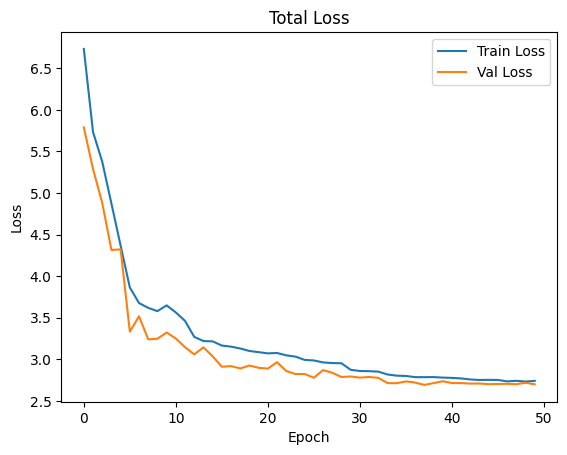

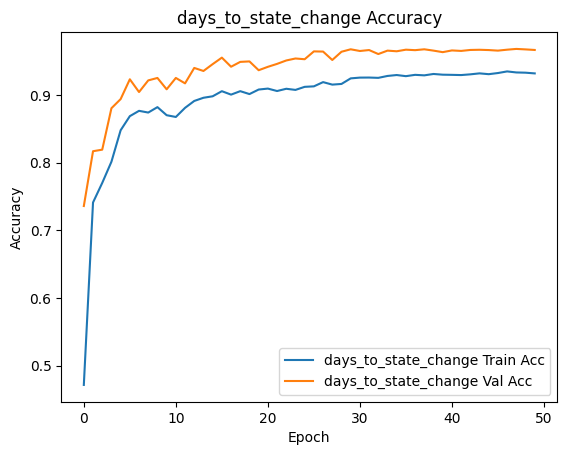

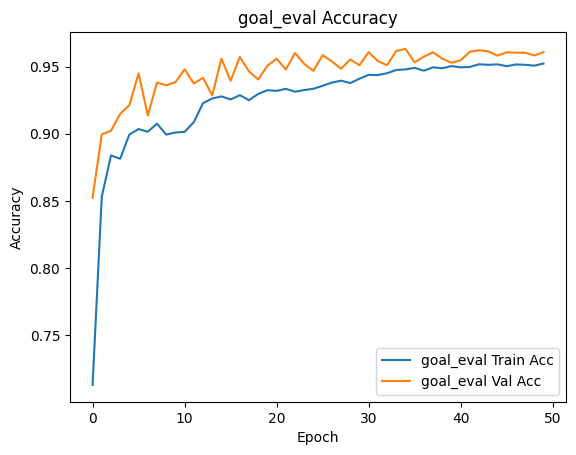

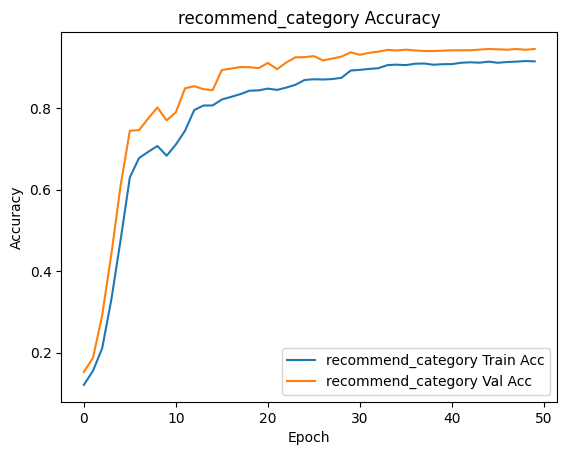

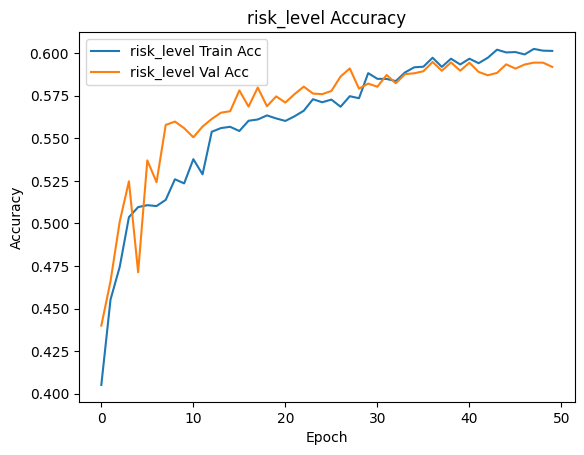

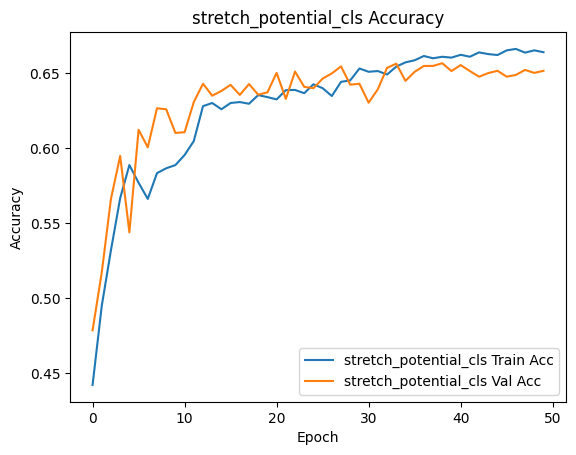

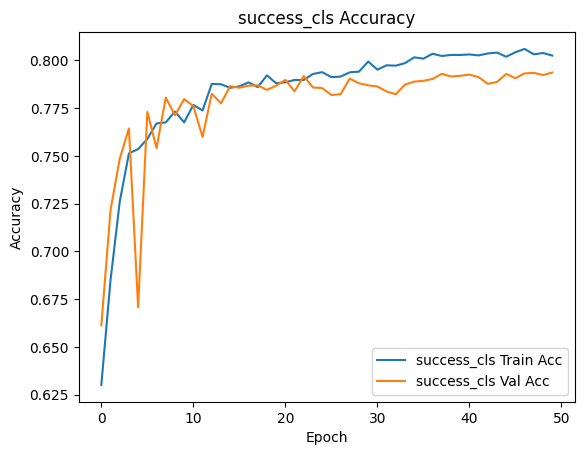

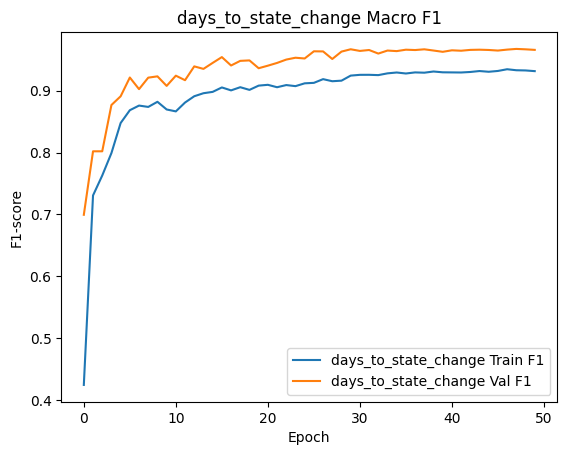

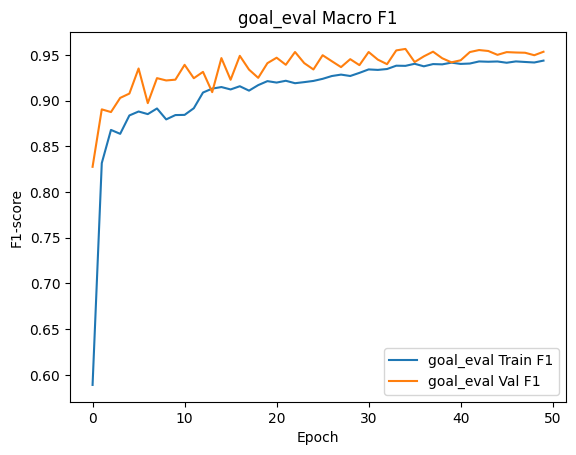

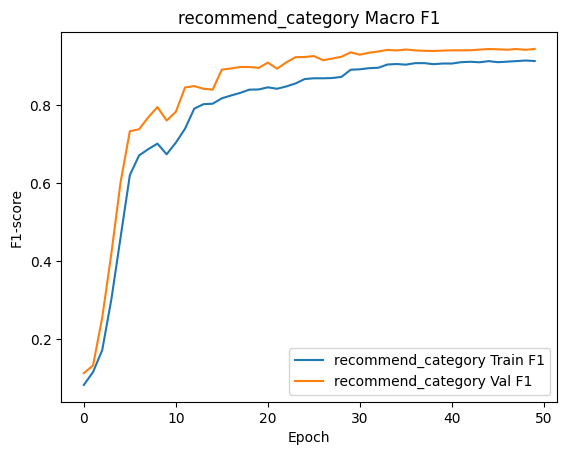

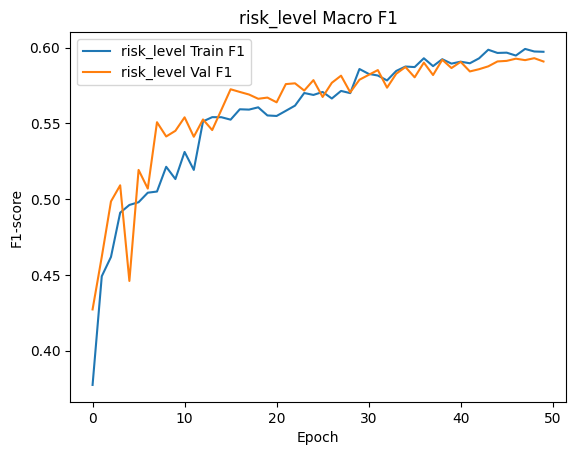

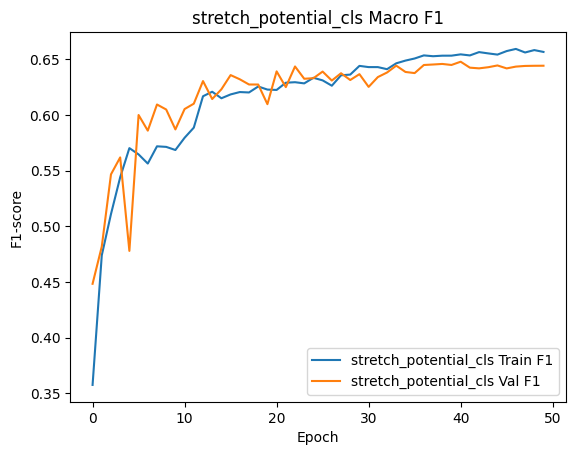

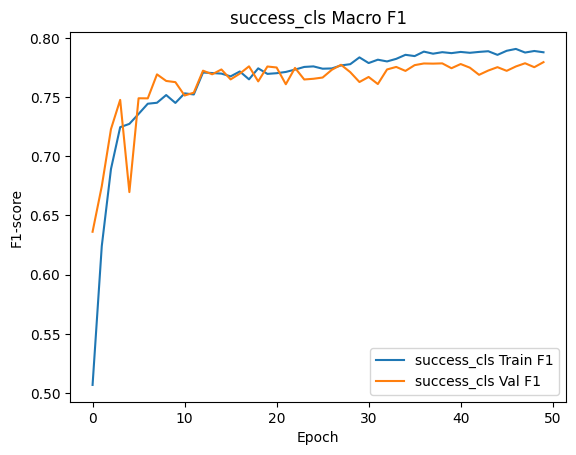

In [24]:

plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Total Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

for head in history["train_acc"]:
    plt.figure()
    plt.plot(history["train_acc"][head], label=f"{head} Train Acc")
    plt.plot(history["val_acc"][head], label=f"{head} Val Acc")
    plt.legend()
    plt.title(f"{head} Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

for head in history["train_f1"]:
    plt.figure()
    plt.plot(history["train_f1"][head], label=f"{head} Train F1")
    plt.plot(history["val_f1"][head], label=f"{head} Val F1")
    plt.legend()
    plt.title(f"{head} Macro F1")
    plt.xlabel("Epoch")
    plt.ylabel("F1-score")
    plt.show()
